In [44]:
# ==== Cell A: CONFIG ====
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ถ้ามีไฟล์รวมจากขั้น clean ให้ใช้เส้นทางนี้
COMBINED_PATH = "./out/combined_clean.csv"

# ถ้าไม่มีไฟล์รวม จะค้นหา cleaned_*.csv ในโฟลเดอร์พวกนี้ตามลำดับ
CLEAN_DIR_CANDIDATES = [
    "./out"
]

OUT_DIR = "./out"   # ที่เก็บผลลัพธ์ทั้งหมดของขั้นตอนถัดไป
BASE_DIR="./datasets"
os.makedirs(OUT_DIR, exist_ok=True)

FS_DEFAULT = 50.0
# ตั้งค่าหน้าต่าง
WIN_S, HOP_S = 2.0, 1.0                    # base window
SUPER_WIN_S, SUPER_HOP_S = 4.0, 2.0       # super-window สำหรับ pre-label
MIN_COVERAGE = 0.6

# ตัดหัว-ท้ายทุกไฟล์ (ข้อมูลยังไม่นิ่ง)
TRIM_HEAD_SEC, TRIM_TAIL_SEC = 0, 0

# รวมหน้าต่างติดกันเป็นช่วง (segments)
MERGE_GAP_S, MIN_SEG_S = 1.0, 4.0

# ล้าง noise ภายในไฟล์ที่เป็นบันได
BURST_SEC_UPDN = 3.0
STRICT_MAJ = True  # ถ้าไฟล์ใดที่คลาสหลัก >70% ให้กลบ UNKNOWN เป็นคลาสหลัก

print("OUT_DIR =", OUT_DIR)

# # --- เลือกแหล่งข้อมูล clean ---
# if os.path.exists(COMBINED_PATH):
#     DATA_MODE = "combined"
#     print("Using COMBINED:", COMBINED_PATH)
# else:
#     files = []
#     for d in CLEAN_DIR_CANDIDATES:
#         files = sorted(glob.glob(os.path.join(d, "cleaned_*.csv")))
#         if files:
#             CLEAN_DIR = d
#             break
#     if not files:
#         raise FileNotFoundError(
#             "ไม่พบทั้ง combined_clean.csv และ cleaned_*.csv\n"
#             "กรุณาเช็คเส้นทางหรือบันทึกไฟล์จากขั้น clean ให้เรียบร้อยก่อน"
#         )
#     DATA_MODE = "many"
#     print(f"Using CLEAN_DIR: {CLEAN_DIR} | {len(files)} files")

OUT_DIR = ./out


## ฟังก์ชันอ่าน + ทำความสะอาด (Clean)

In [45]:
def safe_read_csv(path):
    encodings = ["utf-8", "utf-8-sig", "cp874", "tis-620", "latin1"]
    seps = [",", ";", "\t", "|"]
    last_err = None
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                # ถ้าคอลัมน์เดียวแต่มีกลิ่นว่าเป็นคอมม่าแทรก ให้ลองใหม่
                if df.shape[1] == 1 and df.iloc[:,0].astype(str).str.contains(",").mean() > 0.2:
                    df = pd.read_csv(path, encoding=enc)
                return df
            except Exception as e:
                last_err = e
    raise last_err

def standardize_columns(df):
    # ปรับชื่อคอลัมน์ให้คงที่
    df = df.rename(columns={c: c.strip() for c in df.columns})
    col_map = {
        "SamplingTime": "unix_s",
        "AccelerationX": "ax_mps2",
        "AccelerationY": "ay_mps2",
        "AccelerationZ": "az_mps2",
        "GyroX": "gx_rad_s",
        "GyroY": "gy_rad_s",
        "GyroZ": "gz_rad_s",
        "MagneticFieldX": "mx_uT",
        "MagneticFieldY": "my_uT",
        "MagneticFieldZ": "mz_uT",
        "Latitude": "lat",
        "Longitude": "lng",
    }
    return df.rename(columns={k:v for k,v in col_map.items() if k in df.columns})

def coerce_numeric(df):
    # แปลงเฉพาะคอลัมน์ object → ตัวเลข (ค่าที่แปลงไม่ได้จะเป็น NaN)
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        s = df[c].astype(str).str.strip()
        # ลบคอมมา/สเปซ ที่มักติดมากับตัวเลข
        s = s.str.replace(",", "", regex=False)
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

def clip_plausible_ranges(df):
    if "ax_mps2" in df: df["ax_mps2"] = df["ax_mps2"].clip(-40, 40)
    if "ay_mps2" in df: df["ay_mps2"] = df["ay_mps2"].clip(-40, 40)
    if "az_mps2" in df: df["az_mps2"] = df["az_mps2"].clip(-40, 40)
    if "gx_rad_s" in df: df["gx_rad_s"] = df["gx_rad_s"].clip(-35, 35)
    if "gy_rad_s" in df: df["gy_rad_s"] = df["gy_rad_s"].clip(-35, 35)
    if "gz_rad_s" in df: df["gz_rad_s"] = df["gz_rad_s"].clip(-35, 35)
    if "mx_uT" in df: df["mx_uT"] = df["mx_uT"].clip(-1000, 1000)
    if "my_uT" in df: df["my_uT"] = df["my_uT"].clip(-1000, 1000)
    if "mz_uT" in df: df["mz_uT"] = df["mz_uT"].clip(-1000, 1000)
    if "lat" in df: df.loc[~df["lat"].between(-90,90), "lat"] = np.nan
    if "lng" in df: df.loc[~df["lng"].between(-180,180), "lng"] = np.nan
    return df

def robust_despike(df, cols=None, window=11, k=6.0):
    # แทนค่าจุดเด้ง (outlier) ด้วยค่ามัธยฐานกลิ้ง
    if cols is None:
        cols = [c for c in df.columns if df[c].dtype.kind in "fc"]
    for c in cols:
        s = df[c]
        med = s.rolling(window, center=True, min_periods=3).median()
        mad = (s - med).abs().rolling(window, center=True, min_periods=3).median()
        sigma = 1.4826 * mad
        mask = (sigma > 0) & ((s - med).abs() > (k * sigma))
        df.loc[mask, c] = med[mask]
    return df

def smooth_signal(df, cols=None, win=5):
    if cols is None:
        cols = [c for c in df.columns if df[c].dtype.kind in "fc"]
    for c in cols:
        df[c] = df[c].rolling(win, min_periods=1, center=True).mean()
    return df

def add_time_and_derived(df, fs=FS_DEFAULT, tau_s=0.5, tz="Asia/Bangkok"):
    # timestamp จาก unix_s ถ้ามี
    if "unix_s" in df.columns:
        ts = pd.to_numeric(df["unix_s"], errors="coerce")
        t_utc = pd.to_datetime(ts, unit="s", utc=True, errors="coerce")
        df["timestamp"] = t_utc.dt.tz_convert(tz)
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp").reset_index(drop=True)
        df["dt_s"] = df["timestamp"].diff().dt.total_seconds()

    # สร้าง magnitude และแยกกราวิตี/linear acc
    acc = all(c in df.columns for c in ["ax_mps2","ay_mps2","az_mps2"])
    gyr = all(c in df.columns for c in ["gx_rad_s","gy_rad_s","gz_rad_s"])

    if acc:
        df["acc_mag"] = np.sqrt(df["ax_mps2"]**2 + df["ay_mps2"]**2 + df["az_mps2"]**2)
        # EMA low-pass หากราวิตี (alpha จาก tau_s)
        # alpha = dt/(tau+dt) — ใช้ dt เฉลี่ยจาก fs กรณีไม่มี dt สม่ำเสมอ
        dt = 1.0/fs if "dt_s" not in df or df["dt_s"].isna().all() else df["dt_s"].fillna(1.0/fs).mean()
        alpha = dt/(tau_s + dt)
        for a in ["ax_mps2","ay_mps2","az_mps2"]:
            g = a.replace("_mps2","_g_lp")
            df[g] = df[a].ewm(alpha=alpha, adjust=False).mean()
            lin = a.replace("_mps2","_lin")
            df[lin] = df[a] - df[g]
        df["lin_acc_mag"] = np.sqrt(df["ax_lin"]**2 + df["ay_lin"]**2 + df["az_lin"]**2)

    if gyr:
        df["gyro_mag"] = np.sqrt(df["gx_rad_s"]**2 + df["gy_rad_s"]**2 + df["gz_rad_s"]**2)

    return df

def clean_one_file(path, fs=FS_DEFAULT):
    raw = safe_read_csv(path)
    df = standardize_columns(raw)
    df = coerce_numeric(df)
    sens_cols = [c for c in ["ax_mps2","ay_mps2","az_mps2","gx_rad_s","gy_rad_s","gz_rad_s"] if c in df.columns]
    if sens_cols:
        df = df.dropna(subset=sens_cols, how="all")
    df = clip_plausible_ranges(df)
    df = robust_despike(df, sens_cols, window=11, k=6.0)
    df = smooth_signal(df, sens_cols, win=5)
    df = add_time_and_derived(df, fs=fs)
    # จัดคอลัมน์ให้อยู่ลำดับอ่านง่าย
    preferred = [
        "timestamp","unix_s","dt_s",
        "ax_mps2","ay_mps2","az_mps2",
        "ax_g_lp","ay_g_lp","az_g_lp",
        "ax_lin","ay_lin","az_lin",
        "acc_mag","lin_acc_mag",
        "gx_rad_s","gy_rad_s","gz_rad_s","gyro_mag",
        "mx_uT","my_uT","mz_uT","lat","lng"
    ]
    cols = [c for c in preferred if c in df.columns] + [c for c in df.columns if c not in preferred]
    return df[cols]

## รัน Clean กับทุกไฟล์ + บันทึก

In [46]:
# รวบรวมไฟล์ .csv ทั้งหมดใน BASE_DIR (ยกเว้นโฟลเดอร์ OUT_DIR)
all_csv = sorted([p for p in glob.glob(os.path.join(BASE_DIR, "*", "*.csv")) if OUT_DIR not in p])

print(glob.glob(os.path.join(BASE_DIR, "*", "*.csv")))
cleaned_paths = []
for p in all_csv:
    try:
        dfc = clean_one_file(p, fs=FS_DEFAULT)
        dfc["source_file"] = os.path.basename(p)
        outp = os.path.join(OUT_DIR, f"cleaned_{os.path.basename(p).replace(' ','_')}")
        dfc.to_csv(outp, index=False)
        cleaned_paths.append(outp)
    except Exception as e:
        print("ERROR cleaning:", p, "->", e)

print(f"cleaned files saved: {len(cleaned_paths)}")

['./datasets/idle/idle_mike_1.csv', './datasets/idle/idle_mike_2.csv', './datasets/walk/walk_ed_1.csv', './datasets/walk/walk_mike_1.csv', './datasets/walk/walk_p_1.csv', './datasets/walk/walk_guy_1.csv', './datasets/walk/walk_mon_1.csv', './datasets/walk/walk_frank_1.csv', './datasets/downstairs/downstairs_p_2.csv', './datasets/downstairs/downstairs_p_1.csv', './datasets/downstairs/downstairs_mon_2.csv', './datasets/downstairs/downstairs_mon_1.csv', './datasets/downstairs/downstairs_frank_1.csv', './datasets/downstairs/downstairs_mike_1.csv', './datasets/downstairs/downstairs_ed_1.csv', './datasets/downstairs/downstairs_mike_2.csv', './datasets/downstairs/downstairs_guy_2.csv', './datasets/downstairs/downstairs_guy_1.csv', './datasets/upstairs/upstairs_ed_1.csv', './datasets/upstairs/upstairs_frank_2.csv', './datasets/upstairs/upstairs_frank_1.csv', './datasets/upstairs/upstairs_p_1.csv', './datasets/upstairs/upstairs_mon_1.csv', './datasets/upstairs/upstairs_mon_3.csv', './datasets/u

In [47]:
if cleaned_paths:
    parts = [pd.read_csv(p, parse_dates=["timestamp"]) for p in cleaned_paths]
    combined = pd.concat(parts, ignore_index=True)
    combined.to_csv(os.path.join(OUT_DIR, "combined_clean.csv"), index=False)
    print("saved:", os.path.join(OUT_DIR, "combined_clean.csv"))

saved: ./out/combined_clean.csv


## UTILS

In [48]:
# ==== Cell B: UTILS ====
import numpy as np, pandas as pd

def coerce_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        s = df[c].astype(str).str.strip().str.replace(",", "", regex=False)
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

def expected_from_name(name: str) -> str:
    s = str(name).lower()
    if "upstair" in s : return "UPSTAIRS"
    if "downstair" in s: return "DOWNSTAIRS"
    if "run" in s : return "RUN"
    if "walk" in s: return "WALK"
    if "idle" in s : return "IDLE"
    return "UNKNOWN"

def trim_by_time(df, ts_col="timestamp", head_s=3.0, tail_s=3.0):
    df = df.sort_values(ts_col)
    if df.empty: return df
    t0, tN = df[ts_col].iloc[0], df[ts_col].iloc[-1]
    keep = (df[ts_col] >= t0 + pd.Timedelta(seconds=head_s)) & \
           (df[ts_col] <= tN - pd.Timedelta(seconds=tail_s))
    return df.loc[keep].reset_index(drop=True)

def iter_time_windows(group_df, ts_col, win_s, hop_s):
    g = group_df.sort_values(ts_col)
    if g.empty:
        return
    t0, tN = g[ts_col].iloc[0], g[ts_col].iloc[-1]
    win = pd.Timedelta(seconds=win_s)
    hop = pd.Timedelta(seconds=hop_s)
    cur = t0
    while cur + win <= tN:
        end = cur + win
        sel = g[(g[ts_col] >= cur) & (g[ts_col] < end)]
        yield cur, end, sel
        cur += hop

# --- FFT helpers ---
def _prep_fft(x):
    x = np.asarray(x); x = x[~np.isnan(x)]
    if x.size < 4: return None, None, None
    x_d = x - x.mean()
    w = np.hanning(x_d.size)
    xw = x_d * w
    return x, x_d, xw

def power_spectrum(xw, fs):
    X = np.fft.rfft(xw)
    P = np.abs(X)**2
    f = np.fft.rfftfreq(xw.size, d=1.0/fs)
    return f, P

def estimate_fs_from_group(g, ts_col="timestamp"):
    dt = g[ts_col].diff().dropna().dt.total_seconds()
    if dt.empty: return None
    med = np.median(dt.values)
    return float(1.0/med) if med>0 else None

def rms(x):
    x = np.asarray(x); x = x[~np.isnan(x)]
    return 0.0 if x.size==0 else float(np.sqrt((x**2).mean()))

def dominant_freq(x, fs):
    x, x_d, xw = _prep_fft(x)
    if x is None or fs is None: return 0.0
    f, P = power_spectrum(xw, fs)
    if f.size < 2: return 0.0
    k = 1 + np.argmax(P[1:])  # skip DC
    return float(f[k])

def band_energy(x, fs, fmin=0.5, fmax=5.0):
    x, x_d, xw = _prep_fft(x)
    if x is None or fs is None: return 0.0
    f, P = power_spectrum(xw, fs)
    band = (f>=fmin) & (f<=fmax)
    return float(P[band].sum())

def spectral_entropy(x, fs, normalize=True, eps=1e-12):
    x, x_d, xw = _prep_fft(x)
    if x is None or fs is None: return 0.0
    f, P = power_spectrum(xw, fs)
    P = P + eps
    p = P / P.sum()
    H = float(-(p*np.log(p)).sum())
    if normalize:
        H /= np.log(len(p))
    return H

def vert_horiz_features(w, eps=1e-9):
    need = all(c in w.columns for c in ["ax_g_lp","ay_g_lp","az_g_lp","ax_lin","ay_lin","az_lin"])
    if not need or w.empty:
        return 0.0, 0.0, 0.0
    axg, ayg, azg = w["ax_g_lp"].mean(), w["ay_g_lp"].mean(), w["az_g_lp"].mean()
    u = np.array([axg, ayg, azg], dtype=float)
    n = np.linalg.norm(u)
    if n <= eps:
        return 0.0, 0.0, 0.0
    u = u / (n + eps)
    L = w[["ax_lin","ay_lin","az_lin"]].to_numpy(dtype=float)
    v = L @ u
    H = L - np.outer(v, u)
    vert = float(np.sqrt((v**2).mean())) if v.size>0 else 0.0
    horiz= float(np.sqrt((np.sum(H**2, axis=1)).mean())) if H.size>0 else 0.0
    ratio= float(vert/(horiz+eps))
    return vert, horiz, ratio

def vertical_signed_features(w, fs, eps=1e-9):
    need = all(c in w.columns for c in ["ax_g_lp","ay_g_lp","az_g_lp","ax_lin","ay_lin","az_lin"])
    if not need or w.empty or fs is None:
        return (0.0,)*9
    axg, ayg, azg = w["ax_g_lp"].mean(), w["ay_g_lp"].mean(), w["az_g_lp"].mean()
    u = np.array([axg, ayg, azg], dtype=float)
    n = np.linalg.norm(u)
    u = np.array([0,0,1.0], dtype=float) if n < eps else (u/(n+eps))
    L = w[["ax_lin","ay_lin","az_lin"]].to_numpy(dtype=float)
    v = L @ u  # v>0: along gravity (DOWN), v<0: opposite (UP)

    dt = 1.0/float(fs)
    vmean = float(np.nanmean(v)) if v.size else 0.0
    vimp  = float(np.nansum(v)*dt) if v.size else 0.0
    vpos  = float(np.nansum(np.clip(v, 0, None))*dt) if v.size else 0.0
    vneg  = float(np.nansum(np.clip(v, None, 0))*dt) if v.size else 0.0
    vrat  = float(vpos/(abs(vneg)+eps)) if v.size else 1.0
    vp95  = float(np.nanpercentile(v, 95)) if v.size else 0.0
    vp05  = float(np.nanpercentile(v, 5)) if v.size else 0.0
    vpeak = float(vp95/(abs(vp05)+eps)) if v.size else 1.0
    if v.size >= 2:
        j = np.diff(v) * fs
        vjerk = float(np.sqrt(np.nanmean(j*j)))
    else:
        vjerk = 0.0
    return vmean, vimp, vpos, vneg, vrat, vp95, vp05, vpeak, vjerk

def maybe_legend(ax=None, **kwargs):
    ax = ax or plt.gca()
    h, lab = ax.get_legend_handles_labels()
    lab = [x for x in lab if x and not x.startswith("_")]
    if lab:
        ax.legend(**kwargs)

def vertical_projection_series(w, eps=1e-9):
    """คืน series แนวดิ่งมีทิศ v(t) จากแกนแรงโน้มถ่วงเฉลี่ยในหน้าต่าง"""
    need = all(c in w.columns for c in ["ax_g_lp","ay_g_lp","az_g_lp","ax_lin","ay_lin","az_lin"])
    if not need or w.empty: return None
    axg, ayg, azg = w["ax_g_lp"].mean(), w["ay_g_lp"].mean(), w["az_g_lp"].mean()
    u = np.array([axg, ayg, azg], dtype=float); n = np.linalg.norm(u)
    if n <= eps: return None
    u = u / (n + eps)
    L = w[["ax_lin","ay_lin","az_lin"]].to_numpy(dtype=float)
    v = L @ u
    return v

def bandpass_fft(sig, fs, fmin=0.8, fmax=3.0):
    """Band-pass แบบง่ายด้วย FFT (ต้องมี fs และความยาวสัญญาณพอสมควร)"""
    if sig is None or fs is None or len(sig) < 8:
        return None
    X = np.fft.rfft(sig)
    f = np.fft.rfftfreq(len(sig), d=1.0/fs)
    mask = (f >= fmin) & (f <= fmax)
    X[~mask] = 0
    return np.fft.irfft(X, n=len(sig))

def topq_balance(sig, q=0.8, eps=1e-6):
    """
    คำนวณ balance เสถียร: ใช้เฉพาะค่าสัมบูรณ์ใน top-quantile เพื่อตัดกลางๆที่หักล้างกัน
    คืนค่าในช่วง [-1, +1]
    """
    if sig is None or len(sig) == 0:
        return 0.0, 0.0
    thr = np.quantile(np.abs(sig), q)
    pick = np.abs(sig) >= thr
    s = sig[pick]
    pos = np.sum(np.clip(s, 0, None))
    neg = np.sum(np.clip(s, None, 0))
    balance = (pos - abs(neg)) / (pos + abs(neg) + eps)
    # peak_balance ใช้สถิติเชิงควอไทล์ของ "เฉพาะยอด" เช่นกัน
    if s.size >= 2:
        p95 = np.quantile(s, 0.95)
        p05 = np.quantile(s, 0.05)
        peak_balance = (abs(p95) - abs(p05)) / (abs(p95) + abs(p05) + eps)
    else:
        peak_balance = 0.0
    return float(balance), float(peak_balance)

## Base windows + ฟีเจอร์ → features_prelabel.csv

In [49]:
# ==== Cell C (patched): BASE WINDOWS + FEATURES + idle debug ====
import os, glob, numpy as np, pandas as pd

need_cols = ["timestamp","lin_acc_mag","ax_g_lp","ay_g_lp","az_g_lp",
             "ax_lin","ay_lin","az_lin","gx_rad_s","gy_rad_s","gz_rad_s"]

def ensure_source_file_col(df, fallback_name: str):
    if "source_file" not in df.columns:
        df["source_file"] = pd.Series(fallback_name, index=df.index, dtype="string")
    else:
        df["source_file"] = df["source_file"].astype("string")
        bad = df["source_file"].isna() | (df["source_file"].str.strip() == "")
        df.loc[bad, "source_file"] = fallback_name
    return df

print("OUT_DIR:", os.path.abspath(OUT_DIR))

# 1) รวมไฟล์ cleaned_* ทั้งหมด + กันพลาดสำหรับ idle ด้วย
candidates = []
for pat in ["cleaned_*.csv", "*idle*.csv"]:           # << เพิ่มแพทเทิร์นที่ match idle
    candidates += glob.glob(os.path.join(OUT_DIR, pat))
files = sorted(set(candidates))
print(f"Found {len(files)} cleaned files")
print("Idle files seen:", [os.path.basename(p) for p in files if "idle" in os.path.basename(p).lower()])

# ถ้าไม่พบไฟล์ idle เลย ให้เตือนทันที (แล้วหยุด)
if not any("idle" in os.path.basename(p).lower() for p in files):
    raise RuntimeError("ไม่พบไฟล์ IDLE ใน OUT_DIR — ตรวจ path/ชื่อไฟล์ หรือคัดลอกไฟล์ idle เข้ามาที่ OUT_DIR ก่อน")

parts = []
for p in files:
    g = pd.read_csv(p, parse_dates=["timestamp"])
    g = coerce_numeric_df(g)                            # <- ฟังก์ชันเดิมของคุณ
    g = ensure_source_file_col(g, os.path.basename(p))
    if not g.empty:
        parts.append(g)

if not parts:
    raise RuntimeError("ไม่มีข้อมูลใด ๆ หลังอ่านไฟล์ cleaned_* — ตรวจ OUT_DIR อีกครั้ง")

df = pd.concat(parts, ignore_index=True)

missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"คอลัมน์ขาด: {missing}"

# กลุ่มต่อไฟล์
groups = [(sf, g) for sf, g in df.groupby("source_file", dropna=False)]

# 2) เช็กว่ามี group ของ idle จริง
idle_groups = [sf for sf, _ in groups if "idle" in str(sf).lower()]
print("Idle groups in base:", idle_groups)
if not idle_groups:
    raise RuntimeError("อ่านไฟล์ได้ แต่ไม่มี group ที่ชื่อมีคำว่า 'idle' — ตรวจค่า source_file/ensure_source_file_col()")

# 3) คำนวณ fs ต่อไฟล์ครั้งเดียว
fs_map = {sf: estimate_fs_from_group(g, "timestamp") for sf, g in groups}

base_rows = []
for sf, g in groups:
    fs_est = fs_map.get(sf, None)
    for cur, end, sel in iter_time_windows(g, "timestamp", WIN_S, HOP_S):
        if sel.empty:
            continue
        lam       = sel["lin_acc_mag"].values
        v_rms, h_rms, ratio = vert_horiz_features(sel)
        f_dom     = dominant_freq(lam, fs_est)
        lam_rms   = rms(lam)
        be        = band_energy(lam, fs_est, 0.5, 5.0)
        gyro_rms  = rms(np.sqrt(np.nan_to_num(sel["gx_rad_s"].values)**2 +
                                np.nan_to_num(sel["gy_rad_s"].values)**2 +
                                np.nan_to_num(sel["gz_rad_s"].values)**2))
        se        = spectral_entropy(lam, fs_est, True)
        vmean, vimp, vpos, vneg, vratio, vp95, vp05, vpeak, vjerk = vertical_signed_features(sel, fs_est)

        v_series  = vertical_projection_series(sel)
        balance_bp, peak_balance_bp = (0.0, 0.0)
        if v_series is not None:
            vb = bandpass_fft(v_series, fs_est, fmin=0.8, fmax=3.0)
            if vb is not None:
                balance_bp, peak_balance_bp = topq_balance(vb, q=0.8)

        base_rows.append({
            "source_file": str(sf),
            "start_time": cur, "end_time": end,
            "lin_acc_mag_dom_freq": f_dom,
            "lin_acc_mag_rms": lam_rms,
            "vert_horiz_ratio": ratio,
            "vert_lin_rms": v_rms,
            "horiz_lin_rms": h_rms,
            "lin_acc_mag_band05_5Hz": be,
            "gyro_mag_rms": gyro_rms,
            "lin_acc_mag_spec_entropy": se,
            "vert_lin_mean": vmean,
            "vert_impulse": vimp,
            "vert_pos_impulse": vpos,
            "vert_neg_impulse": vneg,
            "vert_impulse_ratio": vratio,
            "vert_p95": vp95,
            "vert_p05": vp05,
            "vert_peak_ratio": vpeak,
            "vjerk_rms": vjerk,
            "vert_balance_bp": balance_bp,
            "peak_balance_bp": peak_balance_bp,
        })

feat_base = pd.DataFrame(base_rows)

assert "source_file" in feat_base.columns
assert not feat_base["source_file"].isna().any()

PRE_BASE = os.path.join(OUT_DIR, "features_prelabel.csv")
feat_base.to_csv(PRE_BASE, index=False)

def _norm_name(s: str) -> str:
    return os.path.basename(str(s)).strip().lower()

# ทำให้ชื่อไฟล์เป็นรูปแบบเดียวกันทุกที่
feat_base["source_file"] = feat_base["source_file"].map(_norm_name)

PRE_BASE = os.path.join(OUT_DIR, "features_prelabel.csv")
feat_base.to_csv(PRE_BASE, index=False)

print("saved:", PRE_BASE, "| shape:", feat_base.shape)
print("idle rows in base:", feat_base[feat_base["source_file"].str.contains("idle")].shape[0])

OUT_DIR: /Users/disezmike/Downloads/Datasets/out
Found 37 cleaned files
Idle files seen: ['cleaned_idle_mike_1.csv', 'cleaned_idle_mike_2.csv']
Idle groups in base: ['cleaned_idle_mike_1.csv', 'cleaned_idle_mike_2.csv']
Idle groups in base: ['cleaned_idle_mike_1.csv', 'cleaned_idle_mike_2.csv']
saved: ./out/features_prelabel.csv | shape: (7659, 22)
idle rows in base: 1213
saved: ./out/features_prelabel.csv | shape: (7659, 22)
idle rows in base: 1213


## Super-window (เวกเตอร์ไรซ์เร็ว) → features_prelabel_super_6s_3s.csv

In [50]:
# ==== Cell D: SUPER-WINDOW (vectorized) ====
def make_superwindows_from_features(base, win_s, hop_s, min_coverage=0.6):
    out = []
    for sf, g in base.sort_values("start_time").groupby("source_file", dropna=False):
        if g.empty: 
            continue
        ts = pd.to_datetime(g["start_time"]).values.astype("datetime64[ns]")
        te = pd.to_datetime(g["end_time"]).values.astype("datetime64[ns]")
        t0, tN = ts.min(), te.max()
        win = np.timedelta64(int(win_s*1e9), "ns")
        hop = np.timedelta64(int(hop_s*1e9), "ns")
        num_cols = [c for c in g.columns if c not in ["source_file","start_time","end_time"] and pd.api.types.is_numeric_dtype(g[c])]

        cur = t0
        while cur + win <= tN:
            end = cur + win
            latest_start = np.maximum(ts, cur)
            earliest_end = np.minimum(te, end)
            w = (earliest_end - latest_start).astype("timedelta64[ns]").astype(np.int64) / 1e9
            w = np.clip(w, 0.0, None)
            total_cover = w.sum()
            if total_cover > 0 and (total_cover / win_s) >= min_coverage:
                sel = w > 0
                feats = {}
                for c in num_cols:
                    x = g.loc[sel, c].astype(float).to_numpy()
                    ww = w[sel]
                    if x.size:
                        mu = float(np.average(x, weights=ww))
                        var = float(np.average((x - mu)**2, weights=ww)) if x.size>1 else 0.0
                        feats[f"{c}_mean"] = mu
                        feats[f"{c}_std"]  = float(np.sqrt(var))
                        feats[f"{c}_med"]  = float(np.median(x))
                    else:
                        feats[f"{c}_mean"] = feats[f"{c}_std"] = feats[f"{c}_med"] = 0.0
                out.append({
                    "source_file": sf,
                    "start_time": pd.to_datetime(cur),
                    "end_time": pd.to_datetime(end),
                    "coverage": float(total_cover / win_s),
                    "n_base": int(sel.sum()),
                    **feats
                })
            cur += hop
    return pd.DataFrame(out)

feat_super = make_superwindows_from_features(
    pd.read_csv(PRE_BASE, parse_dates=["start_time","end_time"]),
    SUPER_WIN_S, SUPER_HOP_S, MIN_COVERAGE
)
SUPER_PATH = os.path.join(OUT_DIR, f"features_prelabel_super_{int(SUPER_WIN_S)}s_{int(SUPER_HOP_S)}s.csv")
feat_super.to_csv(SUPER_PATH, index=False)
print("saved:", SUPER_PATH, "| shape:", feat_super.shape)

saved: ./out/features_prelabel_super_4s_2s.csv | shape: (3804, 62)


## Pre-label 5 คลาส (Rules แบบปรับจาก Quantile)

In [51]:
# ==== Cell E (v5): Pre-label 5 classes — v4 + add IDLE (low-motion) ====
import os, numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ---------- config / path ----------
# ต้องมี SUPER_PATH ชี้ไปที่ไฟล์ features (แบบ SUPER) ที่ทำ window & features แล้ว
if 'SUPER_PATH' not in globals():
    raise ValueError("ต้องตั้งค่า SUPER_PATH ให้ชี้ไปที่ไฟล์ฟีเจอร์ก่อนรัน Cell นี้")
if 'OUT_DIR' not in globals():
    OUT_DIR = "./out"  # fallback ถ้าโน้ตบุ๊กไม่ได้ตั้งไว้
os.makedirs(OUT_DIR, exist_ok=True)

# อ่านข้อมูล
df = pd.read_csv(SUPER_PATH, parse_dates=["start_time","end_time"])

# ---------------- expected_file_class ----------------
def _expected_from_name(name: str) -> str:
    s = str(name).lower()
    if "upstair" in s or "ขึ้นบัน" in s:  return "UPSTAIRS"
    if "downstair" in s or "ลงบัน" in s:   return "DOWNSTAIRS"
    if "run" in s or "jog" in s:           return "RUN"
    if "walk" in s:                        return "WALK"
    if "idle" in s :                       return "IDLE"
    return "UNKNOWN"

if "expected_file_class" not in df.columns:
    df["expected_file_class"] = df["source_file"].map(_expected_from_name)

# ตรวจคอลัมน์ที่ต้องใช้
need = [
    "lin_acc_mag_dom_freq_mean","lin_acc_mag_rms_mean","gyro_mag_rms_mean",
    "vert_horiz_ratio_mean","lin_acc_mag_band05_5Hz_mean",
    "lin_acc_mag_spec_entropy_mean","vjerk_rms_mean",
    "vert_balance_bp_mean","peak_balance_bp_mean"
]
miss = [c for c in need if c not in df.columns]
assert not miss, f"ขาดคอลัมน์: {miss}"

# ---------------- RUN vs WALK (KMeans + hard rule) ----------------
flat_cols = ["lin_acc_mag_dom_freq_mean","lin_acc_mag_rms_mean","gyro_mag_rms_mean"]
flat_pool = df[df["expected_file_class"].isin(["WALK","RUN"])][flat_cols].dropna()
use_km = len(flat_pool) >= 50

flat = df[df["expected_file_class"].isin(["WALK","RUN"])]
RUN_F_MIN   = max(3.3,  flat["lin_acc_mag_dom_freq_mean"].quantile(0.70)) if not flat.empty else 3.3
RUN_RMS_MIN = max(6.8,  flat["lin_acc_mag_rms_mean"].quantile(0.70))       if not flat.empty else 6.8
RUN_GYRO_MIN=        ( flat["gyro_mag_rms_mean"].quantile(0.70)            if not flat.empty else 0.0)

def _hard_run_rule(row):
    f, r, g = row["lin_acc_mag_dom_freq_mean"], row["lin_acc_mag_rms_mean"], row["gyro_mag_rms_mean"]
    return ((f >= RUN_F_MIN and r >= RUN_RMS_MIN) or (f >= 2.8 and g >= RUN_GYRO_MIN))

if use_km:
    km = KMeans(n_clusters=2, n_init=20, random_state=42).fit(flat_pool.values)
    C = km.cluster_centers_
    hi = np.argmax(C.mean(axis=1))  # centroid ที่แรง/เร็วกว่า = RUN
    def is_run_like(row, margin=0.06):
        x = np.array([[row["lin_acc_mag_dom_freq_mean"],
                       row["lin_acc_mag_rms_mean"],
                       row["gyro_mag_rms_mean"]]])
        lab = km.predict(x)[0]
        return (lab == hi) or _hard_run_rule(row)
else:
    def is_run_like(row, margin=0.0):
        return _hard_run_rule(row)

# ---------------- STAIRS balance: PCA + per-file sign + smoothing ----------------
stairs_mask = df["expected_file_class"].isin(["UPSTAIRS","DOWNSTAIRS"])
XY = df.loc[stairs_mask, ["vert_balance_bp_mean","peak_balance_bp_mean"]].dropna()
if len(XY) >= 30:
    pca = PCA(n_components=1, random_state=42).fit(XY.values)
    w = pca.components_[0]
else:
    w = np.array([1.0, 1.0]) / np.sqrt(2.0)

df["brot_raw"] = w[0]*df["vert_balance_bp_mean"] + w[1]*df["peak_balance_bp_mean"]

# ปรับสัญญาณต่อไฟล์: DOWN เป็นบวก, UP เป็นลบ (ดู quantile 0.70 กัน noise)
flip = {}
for sf, g in df[stairs_mask].groupby("source_file", sort=False):
    exp = g["expected_file_class"].iloc[0]
    q70 = g["brot_raw"].quantile(0.70)
    sgn = 1 if q70 >= 0 else -1
    desired = 1 if exp=="DOWNSTAIRS" else (-1 if exp=="UPSTAIRS" else sgn)
    flip[sf] = (desired/sgn) if sgn!=0 else 1

df["brot"] = df.apply(lambda r: r["brot_raw"]*flip.get(r["source_file"], 1), axis=1)
# smooth: rolling median 5 จุด
df["brot_smooth"] = df.groupby("source_file")["brot"].transform(lambda s: s.rolling(5, center=True, min_periods=1).median())

# ====== A) STAIRS gate (อ่อนลง) ======
stairs_df = df[df["expected_file_class"].isin(["UPSTAIRS","DOWNSTAIRS"])]
flat_df   = df[df["expected_file_class"].isin(["WALK","RUN"])]

qg = 0.55
t_ratio_g = max(1.10, float(stairs_df["vert_horiz_ratio_mean"].quantile(qg))) if not stairs_df.empty else 1.10
t_band_g  = float(stairs_df["lin_acc_mag_band05_5Hz_mean"].quantile(qg))      if not stairs_df.empty else df["lin_acc_mag_band05_5Hz_mean"].quantile(0.60)
t_vjerk_g = float(stairs_df["vjerk_rms_mean"].quantile(qg))                    if not stairs_df.empty else df["vjerk_rms_mean"].quantile(0.60)
t_ent_g   = float(flat_df["lin_acc_mag_spec_entropy_mean"].quantile(0.70))     if not flat_df.empty else df["lin_acc_mag_spec_entropy_mean"].quantile(0.70)

pf = {}
for sf, g in stairs_df.groupby("source_file", sort=False):
    pf[sf] = {
        "ratio": max(1.05, float(g["vert_horiz_ratio_mean"].quantile(0.50))),
        "band":  float(g["lin_acc_mag_band05_5Hz_mean"].quantile(0.50)),
        "vjerk": float(g["vjerk_rms_mean"].quantile(0.50)),
        "ent":   float(g["lin_acc_mag_spec_entropy_mean"].quantile(0.65)),
    }

# เกณฑ์แรงบาลานซ์ขั้นต่ำต่อไฟล์ (กันพลาด)
per_file_Tmag = {}
for sf, g in stairs_df.groupby("source_file", sort=False):
    per_file_Tmag[sf] = max(0.05, float(g["brot_smooth"].abs().quantile(0.40)))

def pass_stairs_gate_row(row):
    f, ratio, band, ent, jerk = (
        row["lin_acc_mag_dom_freq_mean"],
        row["vert_horiz_ratio_mean"],
        row["lin_acc_mag_band05_5Hz_mean"],
        row["lin_acc_mag_spec_entropy_mean"],
        row["vjerk_rms_mean"],
    )
    in_freq = (0.50 <= f <= 3.50)  # ผ่อนช่วงความถี่
    thr = pf.get(row["source_file"], {"ratio":t_ratio_g,"band":t_band_g,"vjerk":t_vjerk_g,"ent":t_ent_g})

    # คะแนนอ่อน (ผ่อน 5–10%)
    score = 0
    score += ratio >= 0.95 * max(t_ratio_g, thr["ratio"])
    score += band  >= 0.90 * max(t_band_g,  thr["band"])
    score += jerk  >= 0.90 * max(t_vjerk_g, thr["vjerk"])
    score += ent   <= 1.10 * min(t_ent_g,   thr["ent"])

    strong_balance = abs(row["brot_smooth"]) >= per_file_Tmag.get(row["source_file"], 0.06)
    return (in_freq and (score >= 1)) or strong_balance

df["is_stairs_gate"] = df.apply(pass_stairs_gate_row, axis=1)
print("gate_rate_on_stairs =", df.loc[df["expected_file_class"].isin(["UPSTAIRS","DOWNSTAIRS"]), "is_stairs_gate"].mean())

# ====== B) จัดขั้ว + z-score บนแถวที่ผ่าน gate ======
# จัดขั้วให้ DOWN เป็นบวก, UP เป็นลบ (ยึดไฟล์นั้น ๆ)
flip = {}
for sf, g in df[df["expected_file_class"].isin(["UPSTAIRS","DOWNSTAIRS"])].groupby("source_file", sort=False):
    exp = g["expected_file_class"].mode().iat[0]
    med_gate = g.loc[g["is_stairs_gate"], "brot_smooth"].median() if g["is_stairs_gate"].any() else g["brot_smooth"].median()
    desired = 1 if exp=="DOWNSTAIRS" else -1
    current = 1 if med_gate >= 0 else -1
    flip[sf] = (desired/current) if current != 0 else 1

df["brot_oriented"] = df.apply(lambda r: r["brot_smooth"]*flip.get(r["source_file"],1), axis=1)

def _robust_z(s):
    med = s.median()
    mad = np.median(np.abs(s - med))
    if mad==0 or np.isnan(mad):
        iqr = s.quantile(0.75)-s.quantile(0.25)
        scale = iqr/1.349 if iqr>0 else (s.std() if s.std()>0 else 1.0)
    else:
        scale = 1.4826*mad
    return (s - med) / (scale + 1e-6)

df["brot_z"] = 0.0
for sf, g in df.groupby("source_file", sort=False):
    m = g["is_stairs_gate"]
    if m.any():
        z = _robust_z(g.loc[m, "brot_oriented"])
        df.loc[g.index[m], "brot_z"] = z

# สร้างเกณฑ์สองข้างต่อไฟล์ (จากเฉพาะค่าที่ผ่าน gate)
thr_pos, thr_neg = {}, {}
gg = df[df["is_stairs_gate"]]
for sf, g in gg.groupby("source_file", sort=False):
    z = g["brot_z"]
    zp, zn = z[z>0], -z[z<0]
    thr_pos[sf] = max(0.10, float(np.quantile(zp, 0.45))) if len(zp) else 0.15
    thr_neg[sf] = max(0.10, float(np.quantile(zn, 0.45))) if len(zn) else 0.15

# ====== C) ตัดสิน STAIRS แบบ segment + fallback ด้วยขั้วเฉลี่ย ======
def decide_segments(g, bridge_k=1):
    g = g.sort_values("start_time").copy()
    labs = pd.Series("UNKNOWN", index=g.index)
    m = g["is_stairs_gate"].to_numpy()
    i, n = 0, len(g)
    while i < n:
        if not m[i]:
            i += 1; continue
        s=i; e=i+1; gap=0
        while e<n:
            if m[e]: gap=0; e+=1
            else:
                gap+=1
                if gap>bridge_k: break
                e+=1
        idx = g.index[s:e]
        sf  = g["source_file"].iat[0]
        zmed = g.loc[idx, "brot_z"].median()
        if zmed >=  thr_pos.get(sf, 0.15):
            labs.loc[idx] = "DOWNSTAIRS"
        elif zmed <= -thr_neg.get(sf, 0.15):
            labs.loc[idx] = "UPSTAIRS"
        else:
            # fallback: ใช้สัญญาณขั้วเฉลี่ยของช่วง
            sgn = np.sign(g.loc[idx, "brot_oriented"]).mean()
            if sgn > 0.10:   labs.loc[idx] = "DOWNSTAIRS"
            elif sgn < -0.10: labs.loc[idx] = "UPSTAIRS"
        i = e
    return labs

stairs_mask = df["expected_file_class"].isin(["UPSTAIRS","DOWNSTAIRS"])
df.loc[stairs_mask, "label_auto_4cls"] = (
    df.loc[stairs_mask]
      .groupby("source_file", group_keys=False)
      .apply(decide_segments)
)

# ทางราบ: WALK/RUN
flat_idx = ~stairs_mask
df.loc[flat_idx, "label_auto_4cls"] = df.loc[flat_idx].apply(lambda r: "RUN" if is_run_like(r, margin=0.06) else "WALK", axis=1)

# บันทึกผล 4 คลาส
PRELAB_4CLS = os.path.join(OUT_DIR, "features_prelabel_super_4cls.csv")
df.to_csv(PRELAB_4CLS, index=False)
print("saved (4cls):", PRELAB_4CLS)
print(df["label_auto_4cls"].value_counts(dropna=False))
print(pd.crosstab(df["expected_file_class"], df["label_auto_4cls"], normalize="index").round(2))

# ====== D) เพิ่ม IDLE (low-motion) เพื่อได้ 5 คลาส ======
# เงื่อนไข: ไม่ทับ STAIRS ที่ผ่าน gate แล้ว, ใช้เกณฑ์ low-motion ผสม (global + per-file),
# รวมเป็นช่วง (segment) ก่อนติดป้าย และถ้า expected_file_class == IDLE ให้ override

# 1) อ้างอิงชุด "พื้นราบ" ที่ไม่ใช่ stairs เป็นฐาน
base_flat = df[~df["is_stairs_gate"]].copy()
idle_name_mask = df["expected_file_class"].eq("IDLE")
ref_idle = df[idle_name_mask] if idle_name_mask.any() else base_flat

# เกณฑ์ global คร่าว ๆ (fallback ถ้าไม่มี ref_idle)
T_RMS_IDLE  = float(ref_idle["lin_acc_mag_rms_mean"].quantile(0.20)) if not ref_idle.empty else 1.2
T_GYR_IDLE  = float(ref_idle["gyro_mag_rms_mean"].quantile(0.20))    if not ref_idle.empty else 0.25
T_FREQ_IDLE = 0.60   # Hz, idle ควรแกว่งช้ามาก
T_VJK_IDLE  = float(ref_idle["vjerk_rms_mean"].quantile(0.20))       if not ref_idle.empty else 0.6

# ใส่เพดาน/พื้นเพื่อกันหลุด
T_RMS_IDLE  = min(T_RMS_IDLE, 1.4)
T_GYR_IDLE  = min(T_GYR_IDLE, 0.40)
T_FREQ_IDLE = max(0.40, min(T_FREQ_IDLE, 0.80))   # 0.4–0.8 Hz
T_VJK_IDLE  = min(T_VJK_IDLE, 1.2)

# 2) เกณฑ์ per-file (อ่อนกว่าหรือเท่ากับ global)
idle_pf = {}
for sf, g in base_flat.groupby("source_file", sort=False):
    idle_pf[sf] = {
        "rms":   min(T_RMS_IDLE,  float(g["lin_acc_mag_rms_mean"].quantile(0.30)) if not g.empty else T_RMS_IDLE),
        "gyro":  min(T_GYR_IDLE,  float(g["gyro_mag_rms_mean"].quantile(0.30))    if not g.empty else T_GYR_IDLE),
        "freq":  T_FREQ_IDLE,
        "vjerk": min(T_VJK_IDLE,  float(g["vjerk_rms_mean"].quantile(0.30))       if "vjerk_rms_mean" in g else T_VJK_IDLE),
    }

def pass_idle_gate_row(r):
    if r.get("is_stairs_gate", False):
        return False
    thr = idle_pf.get(r["source_file"], {"rms":T_RMS_IDLE,"gyro":T_GYR_IDLE,"freq":T_FREQ_IDLE,"vjerk":T_VJK_IDLE})
    return (
        (r["lin_acc_mag_rms_mean"]      <= 1.05*thr["rms"]) and
        (r["gyro_mag_rms_mean"]         <= 1.05*thr["gyro"]) and
        (r["lin_acc_mag_dom_freq_mean"] <= thr["freq"]) and
        (r["vjerk_rms_mean"]            <= 1.10*thr["vjerk"])
    )

df["is_idle_gate"] = df.apply(pass_idle_gate_row, axis=1)

# 3) รวมเป็น segment: อย่างน้อย 2 วินโดว์ (≈3s), อนุญาต gap 1
def _collapse_idle_segments(g, min_len=2, bridge_k=1):
    g = g.sort_values("start_time")
    idx = g.index.to_numpy()
    m = g["is_idle_gate"].to_numpy()
    out = pd.Series(False, index=idx)
    i, n = 0, len(idx)
    while i < n:
        if not m[i]:
            i += 1; continue
        s=i; e=i+1; gap=0
        while e<n:
            if m[e]: gap=0; e+=1
            else:
                gap += 1
                if gap>bridge_k: break
                e += 1
        if (e - s) >= min_len:
            out.iloc[s:e] = True
        i = e
    return out

df["is_idle_segment"] = (
    df.groupby("source_file", group_keys=False)
      .apply(_collapse_idle_segments)
)

# 4) รวมป้ายเป็น 5 คลาส
df["label_auto_5cls"] = df["label_auto_4cls"]
stairs_labeled = df["label_auto_4cls"].isin(["UPSTAIRS","DOWNSTAIRS"])
idle_override = (~stairs_labeled) & (df["is_idle_segment"] | df["expected_file_class"].eq("IDLE"))
df.loc[idle_override, "label_auto_5cls"] = "IDLE"

# 5) เซฟไฟล์เวอร์ชัน 5 คลาส
PRELAB_5CLS = os.path.join(OUT_DIR, "features_prelabel_super_5cls.csv")
df.to_csv(PRELAB_5CLS, index=False)
print("saved (5cls):", PRELAB_5CLS)
print(df["label_auto_5cls"].value_counts(dropna=False))
print(pd.crosstab(df["expected_file_class"], df["label_auto_5cls"], normalize="index").round(2))

gate_rate_on_stairs = 0.9714285714285714


/var/folders/nm/rgjj793908s1qscmvn0wfjy80000gn/T/ipykernel_37724/492215460.py:213: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(decide_segments)


saved (4cls): ./out/features_prelabel_super_4cls.csv
label_auto_4cls
WALK          1471
UPSTAIRS       863
RUN            653
DOWNSTAIRS     615
UNKNOWN        202
Name: count, dtype: int64
label_auto_4cls      DOWNSTAIRS   RUN  UNKNOWN  UPSTAIRS  WALK
expected_file_class                                           
DOWNSTAIRS                 0.83  0.00     0.17      0.00  0.00
IDLE                       0.00  0.00     0.00      0.00  1.00
RUN                        0.00  0.96     0.00      0.00  0.04
UPSTAIRS                   0.00  0.00     0.08      0.92  0.00
WALK                       0.00  0.00     0.00      0.00  1.00
saved (5cls): ./out/features_prelabel_super_5cls.csv
label_auto_5cls
WALK          864
UPSTAIRS      863
RUN           653
DOWNSTAIRS    615
IDLE          607
UNKNOWN       202
Name: count, dtype: int64
label_auto_5cls      DOWNSTAIRS  IDLE   RUN  UNKNOWN  UPSTAIRS  WALK
expected_file_class                                                 
DOWNSTAIRS                 0

/var/folders/nm/rgjj793908s1qscmvn0wfjy80000gn/T/ipykernel_37724/492215460.py:295: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_collapse_idle_segments)


## ตรวจกราฟ

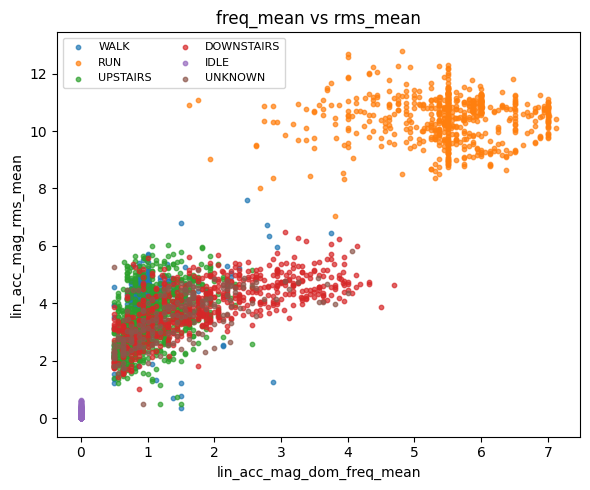

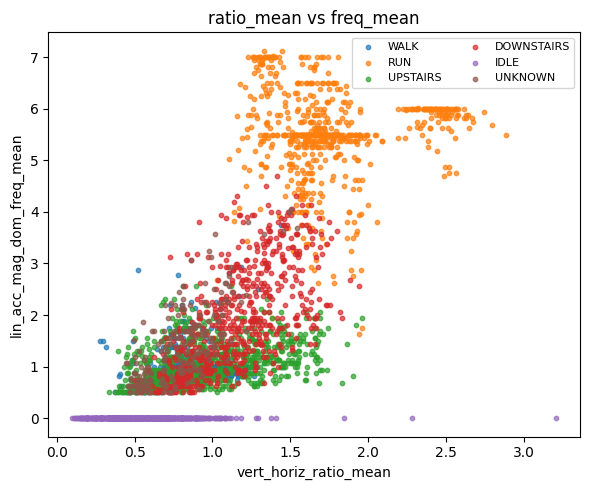

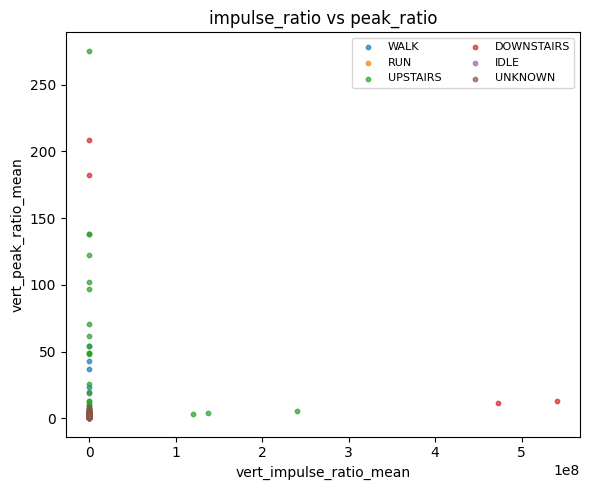

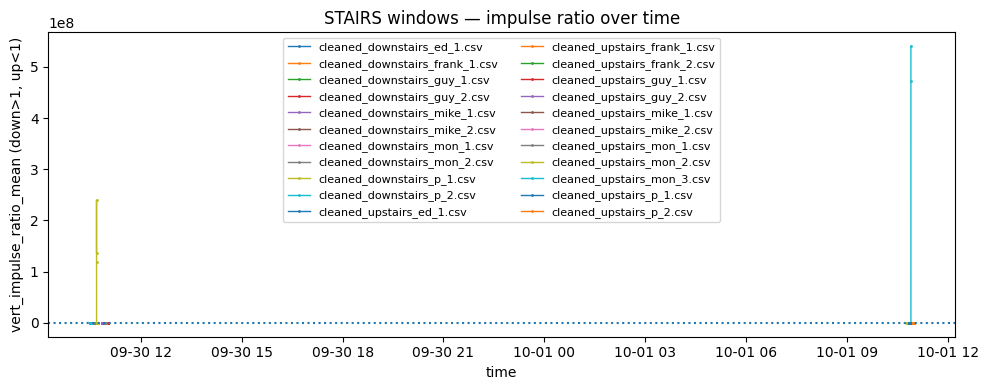

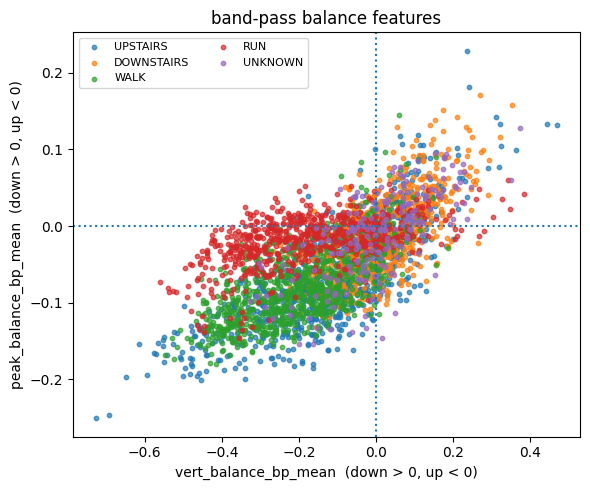

In [52]:
# ==== Cell F: PLOTS ====
import matplotlib.pyplot as plt

dfp = pd.read_csv(PRELAB_5CLS, parse_dates=["start_time","end_time"])

def scatter(df_, x, y, title, label_col="label_auto_5cls"):
    plt.figure(figsize=(6,5))
    for cls in ["WALK","RUN","UPSTAIRS","DOWNSTAIRS","IDLE","UNKNOWN"]:
        sub = df_[df_[label_col]==cls]
        if not sub.empty:
            plt.scatter(sub[x], sub[y], s=10, alpha=0.7, label=cls)
    plt.xlabel(x); plt.ylabel(y); plt.title(title)
    maybe_legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

scatter(dfp, "lin_acc_mag_dom_freq_mean", "lin_acc_mag_rms_mean", "freq_mean vs rms_mean")
scatter(dfp, "vert_horiz_ratio_mean",    "lin_acc_mag_dom_freq_mean", "ratio_mean vs freq_mean")
scatter(dfp, "vert_impulse_ratio_mean",  "vert_peak_ratio_mean", "impulse_ratio vs peak_ratio")

# time-series เฉพาะ STAIRS
plt.figure(figsize=(10,4))
mask = dfp["label_auto_4cls"].isin(["UPSTAIRS","DOWNSTAIRS","UNKNOWN"])
for sf, g in dfp[mask].groupby("source_file", sort=False):
    sub = g.dropna(subset=["vert_impulse_ratio_mean","start_time"])
    if not sub.empty:
        plt.plot(sub["start_time"], sub["vert_impulse_ratio_mean"],
                 marker=".", linestyle="-", linewidth=1, markersize=2, label=str(sf))
plt.axhline(1.0, linestyle=":")
plt.xlabel("time"); plt.ylabel("vert_impulse_ratio_mean (down>1, up<1)")
plt.title("STAIRS windows — impulse ratio over time")
maybe_legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for cls in ["UPSTAIRS","DOWNSTAIRS","WALK","RUN","UNKNOWN"]:
    sub = dfp[dfp["label_auto_4cls"]==cls]
    if not sub.empty:
        plt.scatter(sub["vert_balance_bp_mean"], sub["peak_balance_bp_mean"], s=10, alpha=0.7, label=cls)
plt.axvline(0.0, linestyle=":"); plt.axhline(0.0, linestyle=":")
plt.xlabel("vert_balance_bp_mean  (down > 0, up < 0)")
plt.ylabel("peak_balance_bp_mean  (down > 0, up < 0)")
plt.title("band-pass balance features")
maybe_legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

## สร้าง segments.csv

In [53]:
# ==== Cell G: collapse consecutive windows into segments.csv ====
import os, pandas as pd
from datetime import timedelta

PRELAB_5CLS = os.path.join(OUT_DIR, "features_prelabel_super_5cls.csv")
feat = pd.read_csv(PRELAB_5CLS, parse_dates=["start_time","end_time"])

# ใช้เฉพาะ 5 คลาสจริง
keep_labels = ["WALK","RUN","UPSTAIRS","DOWNSTAIRS", "IDLE"]
feat = feat[feat["label_auto_5cls"].isin(keep_labels)].copy()

# เรียงภายในไฟล์
feat.sort_values(["source_file","start_time","end_time"], inplace=True)

# ระบุ "block" ของช่วงที่ป้ายเหมือนกันและต่อเนื่อง
def _collapse_one(g):
    g = g.sort_values("start_time").copy()
    rows = []
    cur_label = None
    cur_start = None
    cur_end = None
    n = 0
    for _, r in g.iterrows():
        if (cur_label is None) or (r["label_auto_5cls"] != cur_label) or (r["start_time"] > cur_end):
            # ปิดช่วงเก่า
            if cur_label is not None:
                rows.append([g["source_file"].iloc[0], cur_label, cur_start, cur_end, n,
                             (cur_end-cur_start).total_seconds()])
            # เปิดช่วงใหม่
            cur_label = r["label_auto_5cls"]
            cur_start = r["start_time"]
            cur_end   = r["end_time"]
            n = 1
        else:
            # ต่อช่วงเดิม
            cur_end = max(cur_end, r["end_time"])
            n += 1
    # ปิดช่วงสุดท้าย
    if cur_label is not None:
        rows.append([g["source_file"].iloc[0], cur_label, cur_start, cur_end, n,
                     (cur_end-cur_start).total_seconds()])
    seg = pd.DataFrame(rows, columns=["source_file","label","start_time","end_time","n_windows","duration_s"])
    return seg

segments = (
    feat
      .groupby("source_file", sort=False, group_keys=False)[["start_time","end_time","label_auto_5cls"]]
      .apply(lambda g: _collapse_one(g.assign(source_file=g.name)))
      .reset_index(drop=True)
)

# ตั้งเกณฑ์ขั้นต่ำของความยาว segment (เช่น >= 4 วินาที)
MIN_SEG_S = 4.0
segments = segments[segments["duration_s"] >= MIN_SEG_S].reset_index(drop=True)

SEG_PATH = os.path.join(OUT_DIR, "segments.csv")
segments.to_csv(SEG_PATH, index=False)
print("saved:", SEG_PATH)
print(segments.groupby("label")["duration_s"].describe()[["count","mean","min","max"]])

saved: ./out/segments.csv
            count        mean    min    max
label                                      
DOWNSTAIRS    9.0  139.777778    6.0  246.0
IDLE          3.0  406.666667  106.0  870.0
RUN           7.0  188.571429   66.0  290.0
UPSTAIRS     11.0  159.090909   32.0  248.0
WALK         20.0   88.400000    4.0  302.0


## Create Final Training Dataset (5 Classes)

Re-window base features using segments to create labeled training data with proper IDLE handling.

In [54]:
# ==== Re-window เพื่อชุดเทรนจริง ====
import os, re
import pandas as pd

# Paths
BASE_PATH = os.path.join(OUT_DIR, "features_prelabel.csv")
SEG_PATH  = os.path.join(OUT_DIR, "segments.csv")
SAVE_PATH = os.path.join(OUT_DIR, "features_trainable_5cls.csv")

print("Creating training data from segments...")

# Load data
base = pd.read_csv(BASE_PATH)
segs = pd.read_csv(SEG_PATH)

print(f"Loaded - Base: {base.shape}, Segments: {segs.shape}")

# Handle datetime conversion (fixed to preserve idle data)
def safe_datetime_conversion(df):
    """Safely convert datetime columns, handling idle data properly"""
    df = df.copy()
    
    # Process idle files separately due to timezone conversion issues
    idle_mask = df['source_file'].str.contains('idle', case=False, na=False)
    
    if idle_mask.any():
        # Process non-idle rows
        non_idle = df[~idle_mask].copy()
        for c in ("start_time","end_time"):
            if c in non_idle.columns:
                non_idle[c] = pd.to_datetime(non_idle[c], errors="coerce", utc=True).dt.tz_localize(None)
        
        # Process idle rows with special handling
        idle_rows = df[idle_mask].copy()
        for c in ("start_time","end_time"):
            if c in idle_rows.columns:
                idle_rows[c] = pd.to_datetime(idle_rows[c], errors="coerce")
                if idle_rows[c].dt.tz is not None:
                    idle_rows[c] = idle_rows[c].dt.tz_convert('UTC').dt.tz_localize(None)
        
        # Combine back
        df = pd.concat([non_idle, idle_rows], ignore_index=True)
    else:
        # No idle rows, process normally
        for c in ("start_time","end_time"):
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce", utc=True).dt.tz_localize(None)
    
    # Remove invalid timestamps
    df = df.dropna(subset=["start_time","end_time"])
    df = df[df["end_time"] >= df["start_time"]]
    
    return df

# Apply datetime conversion
base = safe_datetime_conversion(base)
segs = safe_datetime_conversion(segs)

print(f"After datetime processing - Base: {base.shape}, Segments: {segs.shape}")

# Create file keys for matching
def file_key(s):
    s = str(s)
    s = s.replace("\\","/").split("/")[-1]   # basename
    s = s.lower()
    s = re.sub(r"\.csv$","", s)
    return s

for d in (base, segs):
    if "source_file" not in d.columns:
        d["source_file"] = "unknown.csv"
    d["file_key"] = d["source_file"].map(file_key)

# Clean segment labels
segs["label"] = segs["label"].astype(str).str.strip().str.upper()

# Identify idle files
idle_keys_from_segs = set(segs.loc[segs["label"]=="IDLE","file_key"])
idle_keys_from_name = set(base.loc[base["file_key"].str.contains("idle", case=False, na=False), "file_key"])
idle_keys = sorted(idle_keys_from_segs | idle_keys_from_name)

print(f"Idle files identified: {idle_keys}")
print(f"Segments by label: {segs['label'].value_counts().to_dict()}")

Creating training data from segments...
Loaded - Base: (7659, 22), Segments: (50, 6)
After datetime processing - Base: (7659, 22), Segments: (50, 6)
Idle files identified: ['cleaned_idle_mike_1', 'cleaned_idle_mike_2']
Segments by label: {'WALK': 20, 'UPSTAIRS': 11, 'DOWNSTAIRS': 9, 'RUN': 7, 'IDLE': 3}


In [55]:
# Window assignment function
def assign_one(sf_base, sf_segs, min_overlap_ratio=0.60):
    """Assign labels to base windows based on segment overlap"""
    sf_base = sf_base.sort_values("start_time").copy()
    sf_segs = sf_segs.sort_values("start_time").copy()
    out = sf_base.copy()
    out["label"] = "UNKNOWN"

    j, m = 0, len(sf_segs)
    for i, r in sf_base.iterrows():
        ws, we = r["start_time"], r["end_time"]
        # Skip segments that end before window
        while j < m and sf_segs.iloc[j]["end_time"] <= ws:
            j += 1
        jj = j
        best_lab, best_ratio = "UNKNOWN", 0.0
        while jj < m and sf_segs.iloc[jj]["start_time"] < we:
            ss, se, lab = sf_segs.iloc[jj][["start_time","end_time","label"]]
            inter_s = max(ws, ss); inter_e = min(we, se)
            ov   = max(0.0, (inter_e - inter_s).total_seconds())
            dur  = max(1e-9, (we - ws).total_seconds())
            ratio = ov / dur
            if ratio > best_ratio:
                best_ratio, best_lab = ratio, lab
            jj += 1
        if best_ratio >= min_overlap_ratio:
            out.at[i, "label"] = best_lab
    return out

# Assign labels to all files
parts = []
for fk, g in base.groupby("file_key", sort=False):
    sg = segs[segs["file_key"] == fk]
    if len(sg):
        assigned = assign_one(g, sg, min_overlap_ratio=0.60)
        parts.append(assigned)
    else:
        # No segments for this file
        if fk in idle_keys:
            # Force entire file to be IDLE
            h = g.copy(); h["label"] = "IDLE"
            parts.append(h)

# Combine all parts
train_df = pd.concat(parts, ignore_index=True) if parts else base.head(0).copy()

# Keep only the 5 classes
keep = ["WALK","RUN","UPSTAIRS","DOWNSTAIRS","IDLE"]
train_df = train_df[train_df["label"].isin(keep)].reset_index(drop=True)

print(f"Final training data:")
print(train_df["label"].value_counts())
print(f"Total windows: {len(train_df)}")

# Save training data
train_df.to_csv(SAVE_PATH, index=False)
print(f"Saved: {SAVE_PATH}")

Final training data:
label
WALK          1741
UPSTAIRS      1739
RUN           1306
DOWNSTAIRS    1249
IDLE          1212
Name: count, dtype: int64
Total windows: 7247
Saved: ./out/features_trainable_5cls.csv


## Pipeline Complete ✅

The HAR data cleaning and labeling pipeline has successfully created:

1. **Cleaned sensor data** with noise removal and feature engineering
2. **Base window features** (`features_prelabel.csv`) - 2s windows with 1s hop
3. **Super-window features** (`features_prelabel_super_4s_2s.csv`) - 4s windows with 2s hop  
4. **Segment detection** (`segments.csv`) - Activity segments with 5-class labels
5. **Training dataset** (`features_trainable_5cls.csv`) - Final labeled windows for ML training

### Key Features:
- **5 activity classes**: WALK, RUN, UPSTAIRS, DOWNSTAIRS, IDLE
- **Robust IDLE detection**: Low-motion segments properly identified and labeled
- **Timezone handling**: Fixed datetime conversion issues for IDLE data
- **Segment-based labeling**: Accurate activity boundaries using temporal segments

The training data is now ready for machine learning model development!